### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely areare you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

For starters, let's define a simple MDP from this picture:
<img src='https://s17.postimg.org/mawroys8f/750px-_Markov_Decision_Process_example.png' width=300px>
_img by MistWiz (Own work) [Public domain], via Wikimedia Commons_

In [1]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [15]:
help(MDP)

Help on class MDP in module mdp:

class MDP(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, transition_probs, rewards, initial_state=None)
 |      Defines an MDP. Compatible with gym Env.
 |      :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
 |          A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
 |          For each state and action, probabilities of next states should sum to 1
 |          If a state has no actions available, it is considered terminal
 |      :param rewards: rewards[s][a][s_next] = r(s,a,s')
 |          A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
 |          The reward for anything not mentioned here is zero.
 |      :param get_initial_state: a state where agent starts or a callable() -> state
 |          By default, picks initial state at random.
 |      
 |      States and actions can be anything you can use as dict keys, but we recommend that you use st

We can now use MDP just as any other gym environment:

In [2]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [3]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [16]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    Q = 0.0
    for state_prime in mdp.get_all_states():
        Q += mdp.get_transition_prob(state, action, state_prime) * (mdp.get_reward(state, action, state_prime) + gamma * state_values[state_prime])
    return Q

In [18]:
import numpy as np
test_Vs = {s : i for i, s in enumerate(mdp.get_all_states())}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.allclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [23]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as per formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0
    
    return max([get_action_value(mdp, state_values, state, a, gamma) for a in mdp.get_possible_actions(state)])

In [24]:
test_Vs_vopy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 0.69)
assert test_Vs == test_Vs_vopy, "please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

In [25]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 0.001 # stop VI if new values are this close to old values (or closer)

# initialize V(s)
state_values = {s : 0 for s in mdp.get_all_states()}


for i in range(num_iter):
    
    # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
    assert isinstance(new_state_values, dict)
    
    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   "%(i, diff), end="")
    print('   '.join("V(%s) = %.3f"%(s, v) for s,v in state_values.items()), end='\n\n')
    state_values = new_state_values
    
    if diff < min_difference:
        print("Terminated"); break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000

iter    1   |   diff: 1.89000   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000

iter    2   |   diff: 1.70100   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 1.890

iter    3   |   diff: 1.13542   |   V(s0) = 1.701   V(s1) = 4.184   V(s2) = 2.060

iter    4   |   diff: 0.73024   |   V(s0) = 1.854   V(s1) = 5.319   V(s2) = 2.871

iter    5   |   diff: 0.61135   |   V(s0) = 2.584   V(s1) = 5.664   V(s2) = 3.540

iter    6   |   diff: 0.54664   |   V(s0) = 3.186   V(s1) = 6.275   V(s2) = 3.989

iter    7   |   diff: 0.49198   |   V(s0) = 3.590   V(s1) = 6.790   V(s2) = 4.535

iter    8   |   diff: 0.42210   |   V(s0) = 4.082   V(s1) = 7.189   V(s2) = 4.959

iter    9   |   diff: 0.36513   |   V(s0) = 4.463   V(s1) = 7.611   V(s2) = 5.352

iter   10   |   diff: 0.32862   |   V(s0) = 4.816   V(s1) = 7.960   V(s2) = 5.717

iter   11   |   diff: 0.29262   |   V(s0) = 5.145   V(s1) = 8.280   V(s2) = 6.032

iter

In [26]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032)  < 0.01
assert abs(state_values['s1'] - 11.169) < 0.01
assert abs(state_values['s2'] - 8.921)  < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [30]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    
    actions = mdp.get_possible_actions(state)
    action_values = [get_action_value(mdp, state_values, state, a, gamma) for a in actions]
    return actions[np.argmax(action_values)]

In [31]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a0'

In [32]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)
    
print("average reward: ", np.mean(rewards))

assert(0.85 < np.mean(rewards) < 1.0)

average reward:  0.9015


### Frozen lake

In [33]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [34]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            print("Terminated"); break
            
    return state_values

In [35]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
Terminated


In [36]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done: break


*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()



after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


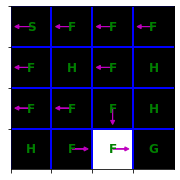

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


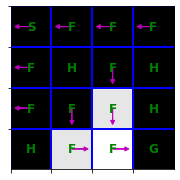

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


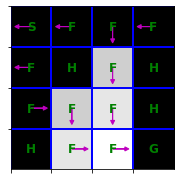

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


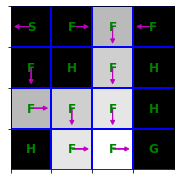

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


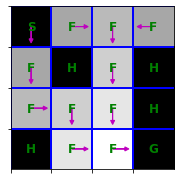

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


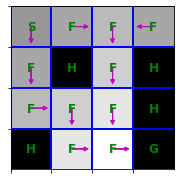

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


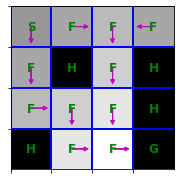

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


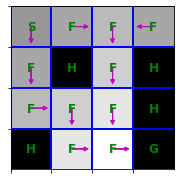

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


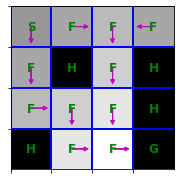

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 
Terminated


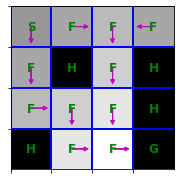

In [38]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 
Terminated


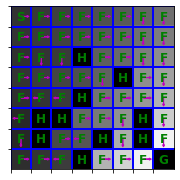

In [39]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [40]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
Terminated
average reward:  1.0
Well done!


In [41]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
Terminated
average reward:  0.881
Well done!


In [42]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [43]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

### Submit to coursera

In [44]:
from submit import submit_assigment
submit_assigment(
    get_action_value, 
    get_new_state_value, 
    get_optimal_action, 
    value_iteration, 
    'ishalyminov@gmail.com', 
    'EGs88oIv2rYVvmSI')